# 第7章：优化技术实践与演示

本notebook旨在通过代码和实验演示优化技术的核心概念，包括参数初始化、优化算法、学习率调度策略以及解决常见优化问题的方法。

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from torch.cuda.amp import autocast, GradScaler

# 设置随机种子以确保结果可复现
torch.manual_seed(42)
np.random.seed(42)

## 1. 参数初始化方法演示

我们将展示不同的参数初始化方法，并观察它们的分布特性以及对训练的影响。

In [8]:
def visualize_distribution(tensor, title):
    """可视化权重分布"""
    plt.figure(figsize=(10, 6))
    plt.hist(tensor.detach().cpu().numpy().flatten(), bins=50)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # 打印统计信息
    print(f"{title} - 均值: {tensor.mean().item():.6f}, 标准差: {tensor.std().item():.6f}")
    print(f"最小值: {tensor.min().item():.6f}, 最大值: {tensor.max().item():.6f}\n")

In [5]:
# 创建多个相同结构的线性层，使用不同的初始化方法
input_size = 784
hidden_size = 256
output_size = 10

# 1. 零初始化
zero_init = nn.Linear(input_size, hidden_size)
zero_init.weight.data.zero_()

# 2. 随机均匀分布初始化
uniform_init = nn.Linear(input_size, hidden_size)
nn.init.uniform_(uniform_init.weight.data, -0.1, 0.1)

# 3. 随机正态分布初始化
normal_init = nn.Linear(input_size, hidden_size)
nn.init.normal_(normal_init.weight.data, mean=0.0, std=0.01)

# 4. Xavier/Glorot初始化
xavier_init = nn.Linear(input_size, hidden_size)
nn.init.xavier_normal_(xavier_init.weight.data)

# 5. He/Kaiming初始化
kaiming_init = nn.Linear(input_size, hidden_size)
nn.init.kaiming_normal_(kaiming_init.weight.data)

# 6. 正交初始化
orthogonal_init = nn.Linear(input_size, hidden_size)
nn.init.orthogonal_(orthogonal_init.weight.data)

# 7. Transformer特定初始化 (GPT风格)
transformer_init = nn.Linear(input_size, hidden_size)
nn.init.normal_(transformer_init.weight.data, mean=0.0, std=0.02)

tensor([[-0.0052,  0.0268,  0.0020,  ..., -0.0103, -0.0212, -0.0260],
        [ 0.0146,  0.0262, -0.0464,  ..., -0.0103,  0.0156, -0.0141],
        [-0.0256, -0.0391,  0.0033,  ...,  0.0072, -0.0301, -0.0333],
        ...,
        [ 0.0251,  0.0278,  0.0024,  ...,  0.0033, -0.0105,  0.0098],
        [-0.0041, -0.0226,  0.0362,  ...,  0.0126,  0.0071,  0.0045],
        [-0.0147,  0.0050,  0.0150,  ...,  0.0013,  0.0244, -0.0252]])

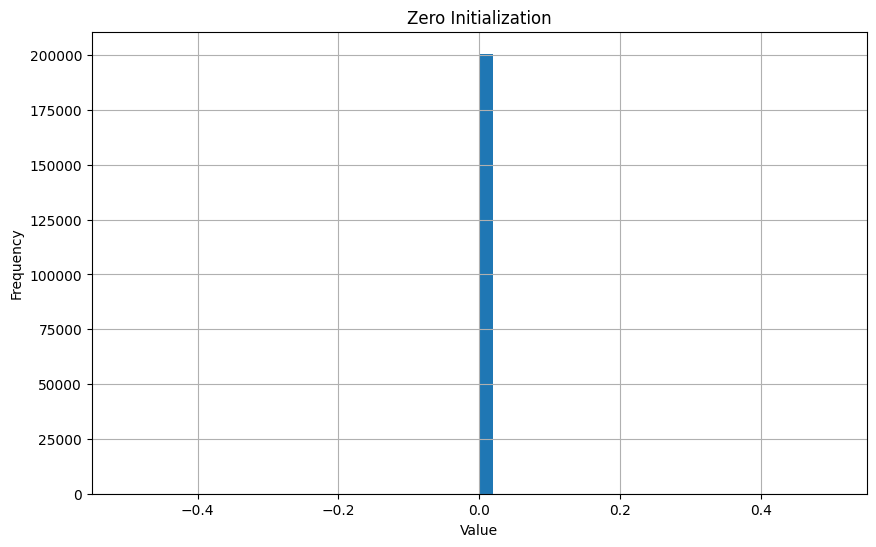

Zero Initialization - 均值: 0.000000, 标准差: 0.000000
最小值: 0.000000, 最大值: 0.000000



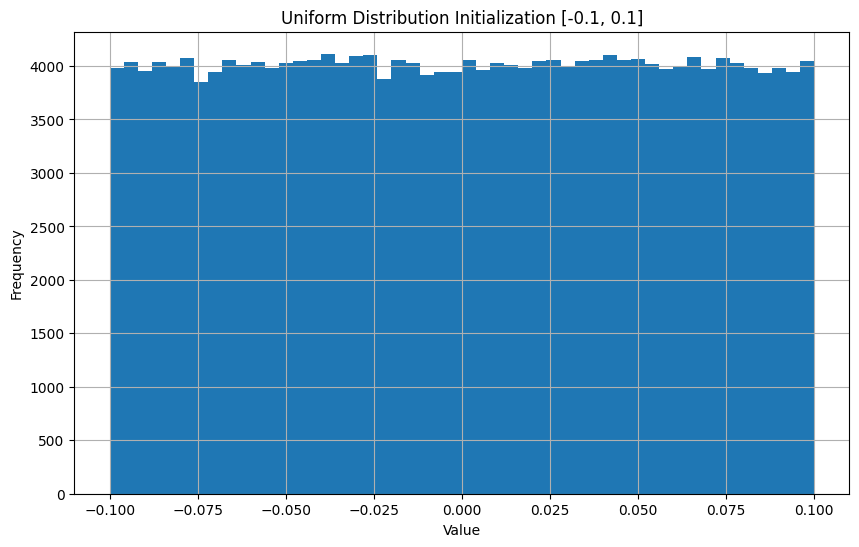

Uniform Distribution Initialization [-0.1, 0.1] - 均值: 0.000029, 标准差: 0.057675
最小值: -0.100000, 最大值: 0.099999



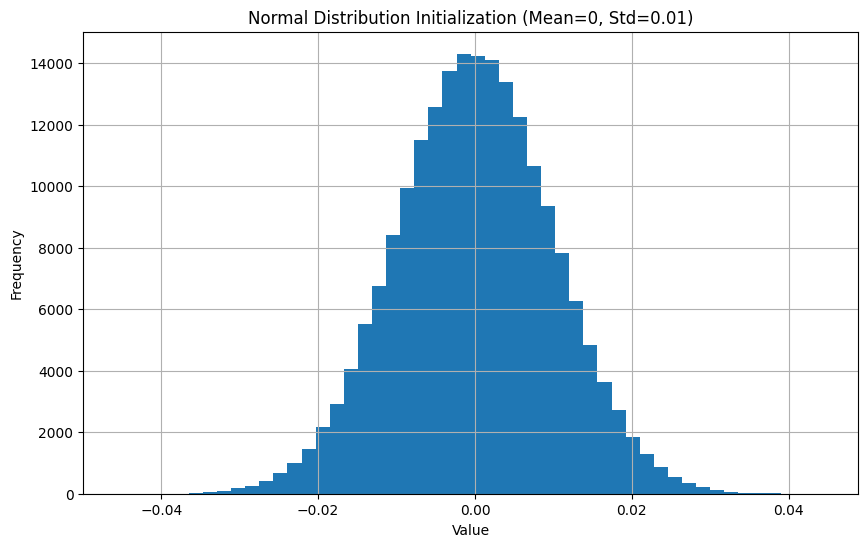

Normal Distribution Initialization (Mean=0, Std=0.01) - 均值: 0.000004, 标准差: 0.009969
最小值: -0.045476, 最大值: 0.044374



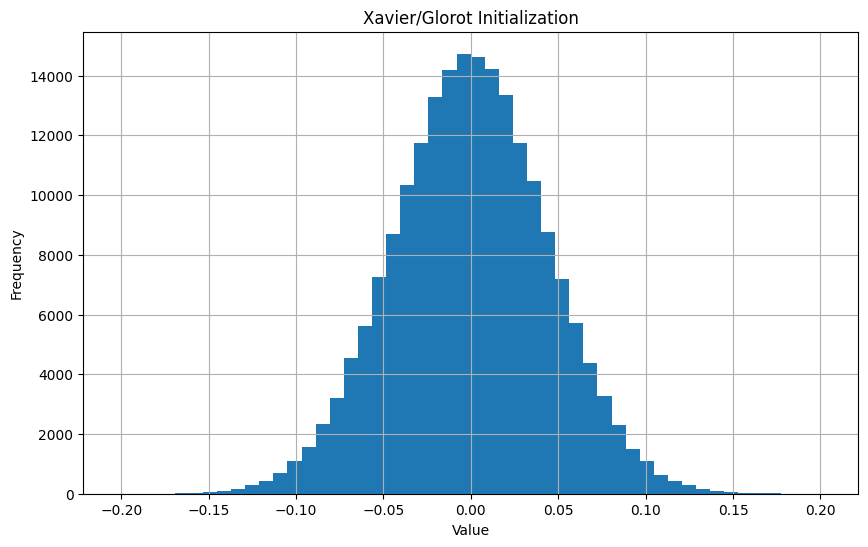

Xavier/Glorot Initialization - 均值: -0.000153, 标准差: 0.043977
最小值: -0.201667, 最大值: 0.201396



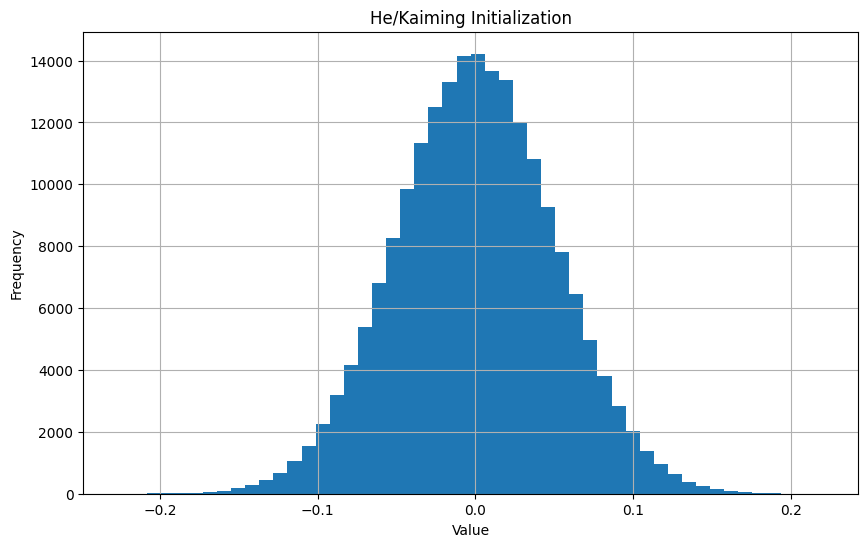

He/Kaiming Initialization - 均值: 0.000042, 标准差: 0.050476
最小值: -0.226486, 最大值: 0.220444



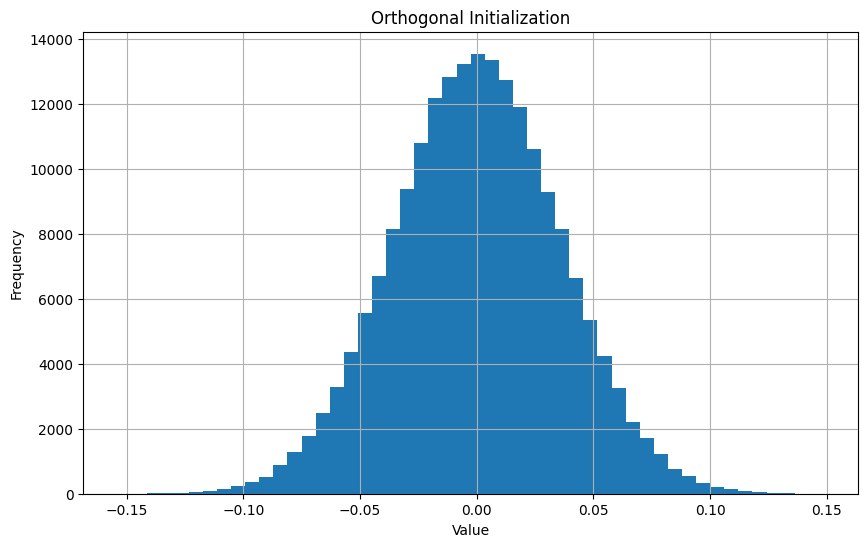

Orthogonal Initialization - 均值: -0.000005, 标准差: 0.035714
最小值: -0.153617, 最大值: 0.148349



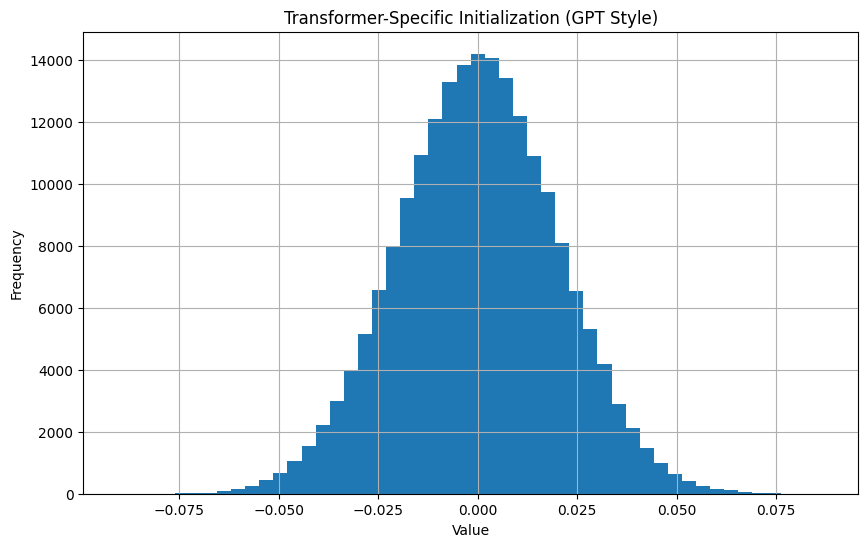

Transformer-Specific Initialization (GPT Style) - 均值: 0.000032, 标准差: 0.020034
最小值: -0.090322, 最大值: 0.086799



In [ ]:
# 可视化不同初始化方法的分布
# 零初始化
visualize_distribution(zero_init.weight, "Zero Initialization")
# 均匀分布初始化 [-0.1, 0.1]
visualize_distribution(uniform_init.weight, "Uniform Distribution Initialization [-0.1, 0.1]")
# 正态分布初始化 (均值=0, 标准差=0.01)
visualize_distribution(normal_init.weight, "Normal Distribution Initialization (Mean=0, Std=0.01)")
# Xavier/Glorot初始化
visualize_distribution(xavier_init.weight, "Xavier/Glorot Initialization")
# He/Kaiming初始化
visualize_distribution(kaiming_init.weight, "He/Kaiming Initialization")
# 正交初始化
visualize_distribution(orthogonal_init.weight, "Orthogonal Initialization")
# Transformer特定初始化 (GPT风格)
visualize_distribution(transformer_init.weight, "Transformer-Specific Initialization (GPT Style)")

### 1.2 初始化方法对激活值分布的影响

我们将检查不同初始化方法对网络前向传播后激活值分布的影响。

In [11]:
# 创建一个简单的三层网络，使用不同的初始化方法
def create_mlp(init_type):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )
    
    # 应用初始化
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if init_type == 'zero':
                nn.init.zeros_(m.weight)
            elif init_type == 'uniform':
                nn.init.uniform_(m.weight, -0.1, 0.1)
            elif init_type == 'normal':
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight)
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight)
            elif init_type == 'transformer':
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                
            nn.init.zeros_(m.bias)
    
    return model

# 创建随机输入数据
input_data = torch.randn(100, input_size)

# 测试不同初始化方法对激活值的影响
init_methods = ['zero', 'uniform', 'normal', 'xavier', 'kaiming', 'orthogonal', 'transformer']
activations = {}

for init_type in init_methods:
    model = create_mlp(init_type)
    model.eval()
    
    # 注册钩子函数来获取中间层的激活值
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    # 注册钩子
    hooks = []
    for i, layer in enumerate(model):
        if isinstance(layer, nn.Linear):
            hooks.append(layer.register_forward_hook(get_activation(f'linear_{i}')))
    
    # 前向传播
    with torch.no_grad():
        model(input_data)
    
    # 存储激活值
    activations[init_type] = activation
    
    # 移除钩子
    for hook in hooks:
        hook.remove()

Zero - 激活值均值: 0.000000, 标准差: 0.000000
Uniform - 激活值均值: -0.163920, 标准差: 0.533849
Normal - 激活值均值: 0.000379, 标准差: 0.003365
Xavier - 激活值均值: 0.054485, 标准差: 0.815411
Kaiming - 激活值均值: 0.560314, 标准差: 1.372096
Orthogonal - 激活值均值: 0.141504, 标准差: 0.524747
Transformer - 激活值均值: 0.007925, 标准差: 0.024235


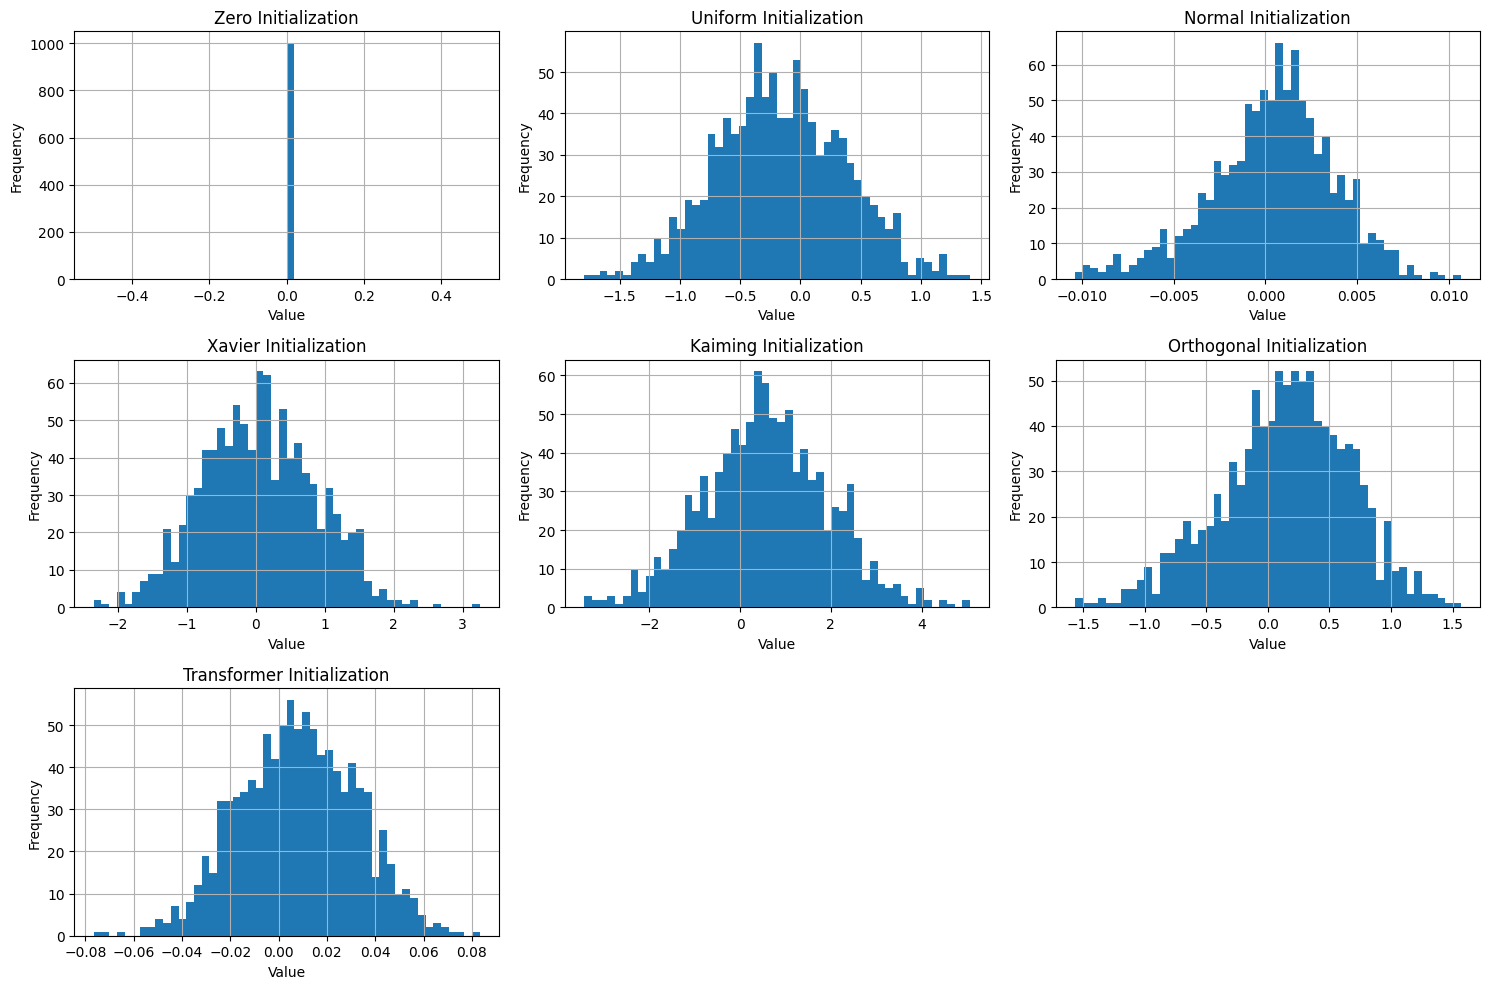

In [ ]:
# 可视化不同初始化方法在最后一层的激活值分布
plt.figure(figsize=(15, 10))

for i, init_type in enumerate(init_methods):
    if 'linear_4' in activations[init_type]:  # 最后一个线性层
        plt.subplot(3, 3, i+1)
        act = activations[init_type]['linear_4'].numpy().flatten()
        plt.hist(act, bins=50)
        # plt.title(f'{init_type.capitalize()} 初始化')
        plt.title(f'{init_type.capitalize()} Initialization')
        # plt.xlabel('激活值')
        # plt.ylabel('频率')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        
        plt.grid(True)
        
        # 打印统计信息
        print(f"{init_type.capitalize()} - 激活值均值: {np.mean(act):.6f}, 标准差: {np.std(act):.6f}")

plt.tight_layout()
plt.show()

## 2. 优化算法的实现与比较

我们将实现和比较不同的优化算法，包括SGD、动量法、Nesterov加速梯度、Adagrad、RMSprop、Adam和AdamW。

### 2.1 优化器的自定义实现

In [15]:
class SGD_Custom:
    def __init__(self, params, lr=0.01):
        self.params = list(params)
        self.lr = lr
    
    def step(self):
        for p in self.params:
            if p.grad is not None:
                p.data.add_(p.grad.data, alpha=-self.lr)
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

class SGD_Momentum_Custom:
    def __init__(self, params, lr=0.01, momentum=0.9):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.velocity = [torch.zeros_like(p.data) for p in self.params]
    
    def step(self):
        for i, p in enumerate(self.params):
            if p.grad is not None:
                self.velocity[i] = self.momentum * self.velocity[i] + p.grad.data
                p.data.add_(self.velocity[i], alpha=-self.lr)
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

class Nesterov_Custom:
    def __init__(self, params, lr=0.01, momentum=0.9):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.velocity = [torch.zeros_like(p.data) for p in self.params]
    
    def step(self):
        for i, p in enumerate(self.params):
            if p.grad is not None:
                old_v = self.velocity[i].clone()
                self.velocity[i] = self.momentum * self.velocity[i] + p.grad.data
                p.data.add_(self.momentum * old_v - (1 + self.momentum) * self.velocity[i], alpha=-self.lr)
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

class Adagrad_Custom:
    def __init__(self, params, lr=0.01, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.eps = eps
        self.grad_square = [torch.zeros_like(p.data) for p in self.params]
    
    def step(self):
        for i, p in enumerate(self.params):
            if p.grad is not None:
                self.grad_square[i].add_(p.grad.data**2)
                step_size = self.lr / (torch.sqrt(self.grad_square[i]) + self.eps)
                p.data.addcmul_(p.grad.data, step_size, value=-1)
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

class RMSprop_Custom:
    def __init__(self, params, lr=0.01, alpha=0.99, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.avg_square = [torch.zeros_like(p.data) for p in self.params]
    
    def step(self):
        for i, p in enumerate(self.params):
            if p.grad is not None:
                self.avg_square[i] = self.alpha * self.avg_square[i] + (1 - self.alpha) * (p.grad.data **2)
                step_size = self.lr / (torch.sqrt(self.avg_square[i]) + self.eps)
                p.data.addcmul_(p.grad.data, step_size, value=-1)
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

class Adam_Custom:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.m = [torch.zeros_like(p.data) for p in self.params]  # 一阶矩估计
        self.v = [torch.zeros_like(p.data) for p in self.params]  # 二阶矩估计
        self.t = 0  # 时间步
    
    def step(self):
        self.t += 1
        beta1, beta2 = self.betas
        
        for i, p in enumerate(self.params):
            if p.grad is not None:
                # 更新偏置修正的一阶矩估计
                self.m[i] = beta1 * self.m[i] + (1 - beta1) * p.grad.data
                m_hat = self.m[i] / (1 - beta1 ** self.t)
                
                # 更新偏置修正的二阶矩估计
                self.v[i] = beta2 * self.v[i] + (1 - beta2) * (p.grad.data **2)
                v_hat = self.v[i] / (1 - beta2 ** self.t)
                
                # 更新参数
                p.data.addcdiv_(m_hat, torch.sqrt(v_hat) + self.eps, value=-self.lr)
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

class AdamW_Custom:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [torch.zeros_like(p.data) for p in self.params]  # 一阶矩估计
        self.v = [torch.zeros_like(p.data) for p in self.params]  # 二阶矩估计
        self.t = 0  # 时间步
    
    def step(self):
        self.t += 1
        beta1, beta2 = self.betas
        
        for i, p in enumerate(self.params):
            if p.grad is not None:
                # 更新偏置修正的一阶矩估计
                self.m[i] = beta1 * self.m[i] + (1 - beta1) * p.grad.data
                m_hat = self.m[i] / (1 - beta1 ** self.t)
                
                # 更新偏置修正的二阶矩估计
                self.v[i] = beta2 * self.v[i] + (1 - beta2) * (p.grad.data ** 2)
                v_hat = self.v[i] / (1 - beta2 ** self.t)
                
                # 更新参数（注意权重衰减项的位置）
                p.data.mul_(1 - self.lr * self.weight_decay)  # 权重衰减
                p.data.addcdiv_(m_hat, torch.sqrt(v_hat) + self.eps, value=-self.lr)
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

### 2.2 在简单任务上比较优化器性能

我们将创建一个简单的优化问题来比较不同优化器的收敛性能。

In [27]:
# 首先定义 QuadraticFunction 类
class QuadraticFunction(nn.Module):
    """简单的二次函数优化问题"""
    def __init__(self, dims=2):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dims) * 5)  # 初始点(5, 5)
    
    def forward(self):
        return torch.sum(self.weight ** 2)  # f(x, y) = x^2 + y^2

In [28]:
def get_optimizers(model):
    """返回不同优化器的字典集合
    
    参数:
        model: 需要优化的PyTorch模型
    
    返回:
        包含不同优化器的字典
    """
    return {
        'SGD': optim.SGD(model.parameters(), lr=0.1),
        'SGD+Momentum': optim.SGD(model.parameters(), lr=0.1, momentum=0.9),
        'SGD+Nesterov': optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True),
        'Adagrad': optim.Adagrad(model.parameters(), lr=0.5),
        'RMSprop': optim.RMSprop(model.parameters(), lr=0.01),
        'Adam': optim.Adam(model.parameters(), lr=0.1),
        'AdamW': optim.AdamW(model.parameters(), lr=0.1, weight_decay=0.01)
    }

运行 SGD 优化器...
运行 SGD+Momentum 优化器...
运行 SGD+Nesterov 优化器...
运行 Adagrad 优化器...
运行 RMSprop 优化器...
运行 Adam 优化器...
运行 AdamW 优化器...


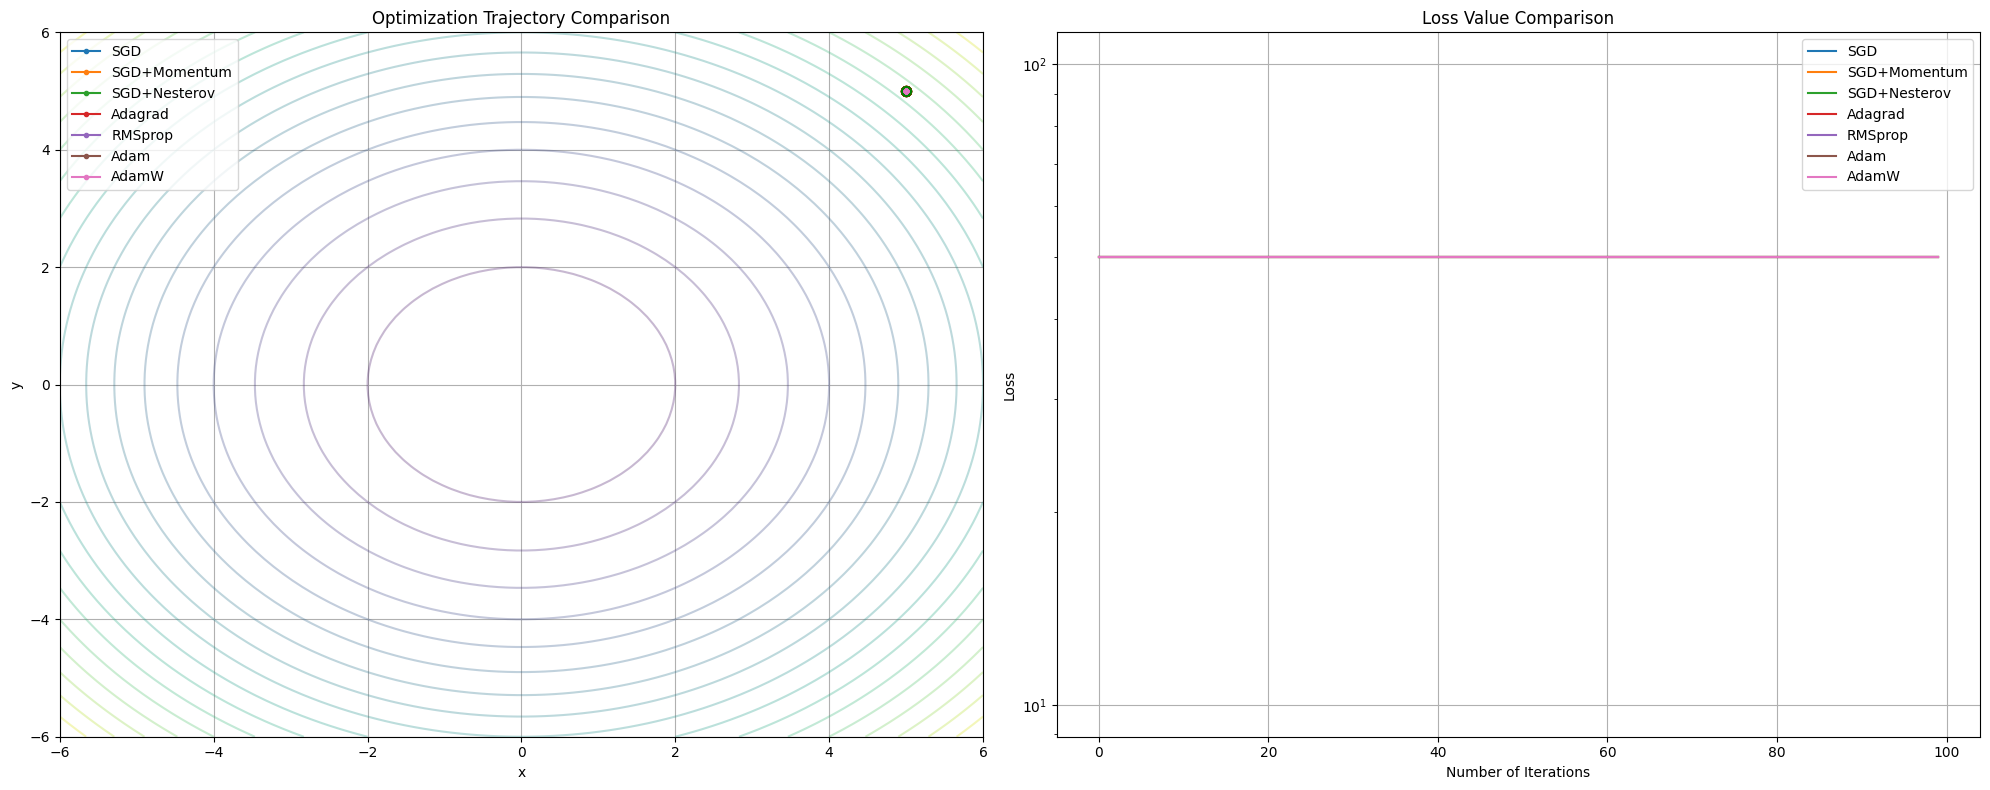

In [30]:
def optimize_and_record(optimizer_name, optimizer, num_iterations=100):
    """运行优化并记录轨迹和损失
    
    参数:
        optimizer_name: 优化器名称(用于显示)
        optimizer: 优化器实例
        num_iterations: 迭代次数
    
    返回:
        trajectory: 参数轨迹
        losses: 损失值列表
    """
    model = QuadraticFunction()
    trajectory = [model.weight.data.clone().numpy()]
    losses = []
    
    for i in range(num_iterations):
        optimizer.zero_grad()
        loss = model()
        loss.backward()
        optimizer.step()
        
        trajectory.append(model.weight.data.clone().numpy())
        losses.append(loss.item())
    
    return trajectory, losses

def plot_trajectories(trajectories, losses):
    """可视化优化轨迹和损失曲线
    
    参数:
        trajectories: 各优化器的参数轨迹
        losses: 各优化器的损失值
    """
    plt.figure(figsize=(20, 8))
    
    # 绘制2D轨迹
    plt.subplot(1, 2, 1)
    for name, trajectory in trajectories.items():
        traj = np.array(trajectory)
        plt.plot(traj[:, 0], traj[:, 1], '-o', label=name, markersize=3)
        plt.scatter(traj[0, 0], traj[0, 1], c='red', s=50)  # 起点
        plt.scatter(traj[-1, 0], traj[-1, 1], c='green', s=50)  # 终点
    
    # plt.title('优化轨迹比较')
    # plt.xlabel('x')
    # plt.ylabel('y')
    plt.title('Optimization Trajectory Comparison')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.legend()
    
    # 等高线
    x = np.linspace(-6, 6, 100)
    y = np.linspace(-6, 6, 100)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + Y**2
    plt.contour(X, Y, Z, levels=20, alpha=0.3)
    
    # 绘制损失曲线
    plt.subplot(1, 2, 2)
    for name, loss in losses.items():
        plt.plot(loss, label=name)
        
    # plt.title('损失值比较')
    # plt.xlabel('迭代次数')
    # plt.ylabel('损失')
    plt.title('Loss Value Comparison')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

# 现在可以正确运行比较代码
optimizers = get_optimizers(QuadraticFunction())
trajectories = {}
losses = {}

for name, opt in optimizers.items():
    print(f"运行 {name} 优化器...")
    trajectory, loss = optimize_and_record(name, opt, num_iterations=100)
    trajectories[name] = trajectory
    losses[name] = loss

plot_trajectories(trajectories, losses)

## 3. 学习率调度策略

我们将实现并比较不同的学习率调度策略。

In [34]:
# 创建一个简单的MLP模型用于文本分类
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=100, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 创建合成数据集
class SyntheticDataset(Dataset):
    def __init__(self, num_samples=1000, input_dim=300, num_classes=10):
        self.data = torch.randn(num_samples, input_dim)
        self.targets = torch.randint(0, num_classes, (num_samples,))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# 创建学习率调度器
def get_schedulers(optimizer):
    return {
        'Constant': optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 1.0),  # 固定学习率
        'Step': optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1),  # 步长衰减
        'Exponential': optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95), # 指数衰减
        'Cosine': optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5), # 余弦退火
        'CosineWarmRestarts': optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2), # 带重启的余弦退火
        'ReduceLROnPlateau': optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10) # 基于指标的自适应调度
    }

# 自定义线性预热后余弦衰减调度器
def get_linear_warmup_cosine_decay_scheduler(optimizer, warmup_epochs=10, total_epochs=100):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            return 0.5 * (1 + math.cos((epoch - warmup_epochs) * math.pi / (total_epochs - warmup_epochs)))
    
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# 可视化学习率变化
def plot_lr_schedule(schedulers, scheduler_types, total_epochs=100):
    plt.figure(figsize=(12, 6))
    
    for name, scheduler in schedulers.items():
        if name == 'ReduceLROnPlateau':
            # 这个调度器需要验证指标，我们模拟一个递减的损失
            lrs = []
            for epoch in range(total_epochs):
                lrs.append(scheduler.optimizer.param_groups[0]['lr'])
                # 模拟验证损失，逐渐降低然后平稳
                val_loss = 1.0 / (epoch + 1) + 0.1
                scheduler.step(val_loss)
        else:
            lrs = []
            for epoch in range(total_epochs):
                lrs.append(scheduler.optimizer.param_groups[0]['lr'])
                scheduler.step()
                
        plt.plot(lrs, label=name)
    
    # 添加线性预热后余弦衰减
    model = SimpleClassifier()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    warmup_scheduler = get_linear_warmup_cosine_decay_scheduler(optimizer, warmup_epochs=10, total_epochs=total_epochs)
    
    lrs = []
    for epoch in range(total_epochs):
        lrs.append(warmup_scheduler.optimizer.param_groups[0]['lr'])
        warmup_scheduler.step()
    
    # 自定义的线性预热+余弦衰减策略
    plt.plot(lrs, label='LinearWarmupCosineDecay')
    
    # plt.title('学习率调度策略比较')
    # plt.xlabel('轮次 (Epoch)')
    # plt.ylabel('学习率')
    plt.title('Comparison of Learning Rate Scheduling Strategies')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.legend()
    plt.show()

/Users/gatilin/miniconda3/envs/pro/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


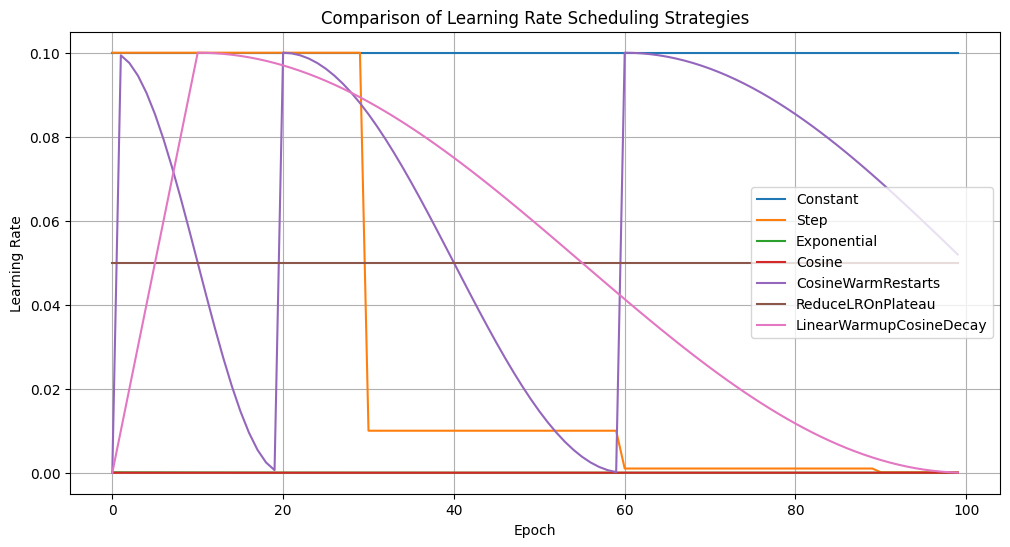

In [33]:
# 创建模型和优化器
model = SimpleClassifier()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# 获取各种调度器
schedulers = get_schedulers(optimizer)
scheduler_types = list(schedulers.keys())

# 可视化学习率变化
plot_lr_schedule(schedulers, scheduler_types, total_epochs=100)

## 4. 优化问题解决方案

我们将演示如何解决常见的优化问题，包括梯度消失/爆炸、训练不稳定以及提高训练效率的技术。

In [38]:
# 创建一个非常深的网络来演示梯度消失/爆炸问题
class DeepNetwork(nn.Module):
    def __init__(self, depth=50, width=20, init_type='normal'):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            layer = nn.Linear(width, width)
            # 应用不同的初始化方法
            if init_type == 'normal':
                nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(layer.weight)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(layer.weight)
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(layer.weight)
                
            self.layers.append(layer)
        
        self.output_layer = nn.Linear(width, 1)
    
    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))  # tanh激活函数容易导致梯度消失
        return self.output_layer(x)

# 分析梯度在不同深度的分布
def analyze_gradients(model, input_data, target):
    # 前向传播
    output = model(input_data)
    loss = F.mse_loss(output, target)
    loss.backward()
    
    # 收集不同层的梯度范数
    grad_norms = []
    for layer in model.layers:
        if layer.weight.grad is not None:
            grad_norm = layer.weight.grad.norm().item()
            grad_norms.append(grad_norm)
    
    return grad_norms

# 比较不同初始化方法对梯度分布的影响
def compare_init_methods_gradients():
    init_methods = ['normal', 'xavier', 'kaiming', 'orthogonal']
    depth = 50
    width = 20
    batch_size = 32
    
    # 创建随机输入数据和目标
    input_data = torch.randn(batch_size, width)
    target = torch.randn(batch_size, 1)
    
    plt.figure(figsize=(12, 8))
    
    for init_type in init_methods:
        model = DeepNetwork(depth=depth, width=width, init_type=init_type)
        grad_norms = analyze_gradients(model, input_data, target)
        
        plt.plot(grad_norms, label=f'{init_type.capitalize()} Initialization')
    
    # plt.title('不同初始化方法的梯度范数分布')
    # plt.xlabel('层索引')
    # plt.ylabel('梯度范数 (log尺度)')
    # plt.yscale('log')
    plt.title('Gradient norm distribution of different initialization methods')
    plt.xlabel('Layer index')
    plt.ylabel('Gradient norm (log scale)')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()

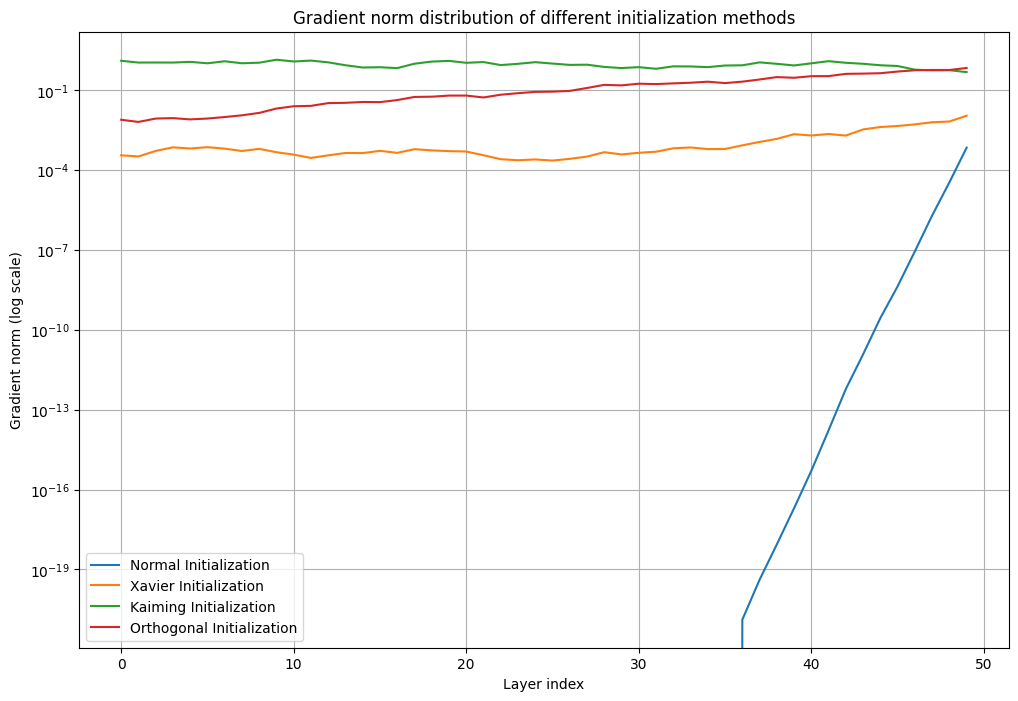

In [39]:
# 比较不同初始化方法对梯度分布的影响
compare_init_methods_gradients()

4.2 梯度裁剪和梯度归一化

In [40]:
# 演示梯度裁剪和梯度归一化的效果
def train_with_gradient_techniques(model, input_data, target, max_norm=1.0, use_clip=True, use_normalize=False):
    # 前向传播
    output = model(input_data)
    loss = F.mse_loss(output, target)
    loss.backward()
    
    # 保存原始梯度
    original_grads = []
    for layer in model.layers:
        if layer.weight.grad is not None:
            original_grads.append(layer.weight.grad.norm().item())
    
    # 应用梯度裁剪或归一化
    if use_clip:
        # 方法1: 基于范数的梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
    elif use_normalize:
        # 方法2: 梯度归一化
        for p in model.parameters():
            if p.grad is not None:
                p.grad.data = p.grad.data / (p.grad.data.norm() + 1e-8) * min(p.grad.data.norm(), max_norm)
    
    # 保存处理后的梯度
    processed_grads = []
    for layer in model.layers:
        if layer.weight.grad is not None:
            processed_grads.append(layer.weight.grad.norm().item())
    
    return original_grads, processed_grads

# 比较不同梯度处理技术的效果
def compare_gradient_techniques():
    depth = 50
    width = 20
    batch_size = 32
    
    # 创建随机输入数据和目标
    input_data = torch.randn(batch_size, width)
    target = torch.randn(batch_size, 1)
    
    # 创建一个模型用于演示梯度裁剪
    model_clip = DeepNetwork(depth=depth, width=width, init_type='normal')
    original_grads_clip, clipped_grads = train_with_gradient_techniques(
        model_clip, input_data, target, max_norm=1.0, use_clip=True, use_normalize=False)
    
    # 创建一个模型用于演示梯度归一化
    model_norm = DeepNetwork(depth=depth, width=width, init_type='normal')
    original_grads_norm, normalized_grads = train_with_gradient_techniques(
        model_norm, input_data, target, max_norm=1.0, use_clip=False, use_normalize=True)
    
    # 可视化比较
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    # plt.plot(original_grads_clip, label='原始梯度')
    # plt.plot(clipped_grads, label='裁剪后梯度')
    # plt.title('梯度裁剪效果')
    # plt.xlabel('层索引')
    # plt.ylabel('梯度范数')
    # plt.yscale('log')
    plt.plot(original_grads_clip, label='Original gradients')
    plt.plot(clipped_grads, label='Clipped gradients')
    plt.title('Effect of gradient clipping')
    plt.xlabel('Layer index')
    plt.ylabel('Gradient norm')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    # plt.plot(original_grads_norm, label='原始梯度')
    # plt.plot(normalized_grads, label='归一化后梯度')
    # plt.title('梯度归一化效果')
    # plt.xlabel('层索引')
    # plt.ylabel('梯度范数')
    # plt.yscale('log')
    plt.plot(original_grads_norm, label='Original gradients')
    plt.plot(normalized_grads, label='Normalized gradients')
    plt.title('Effect of gradient normalization')
    plt.xlabel('Layer index')
    plt.ylabel('Gradient norm')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

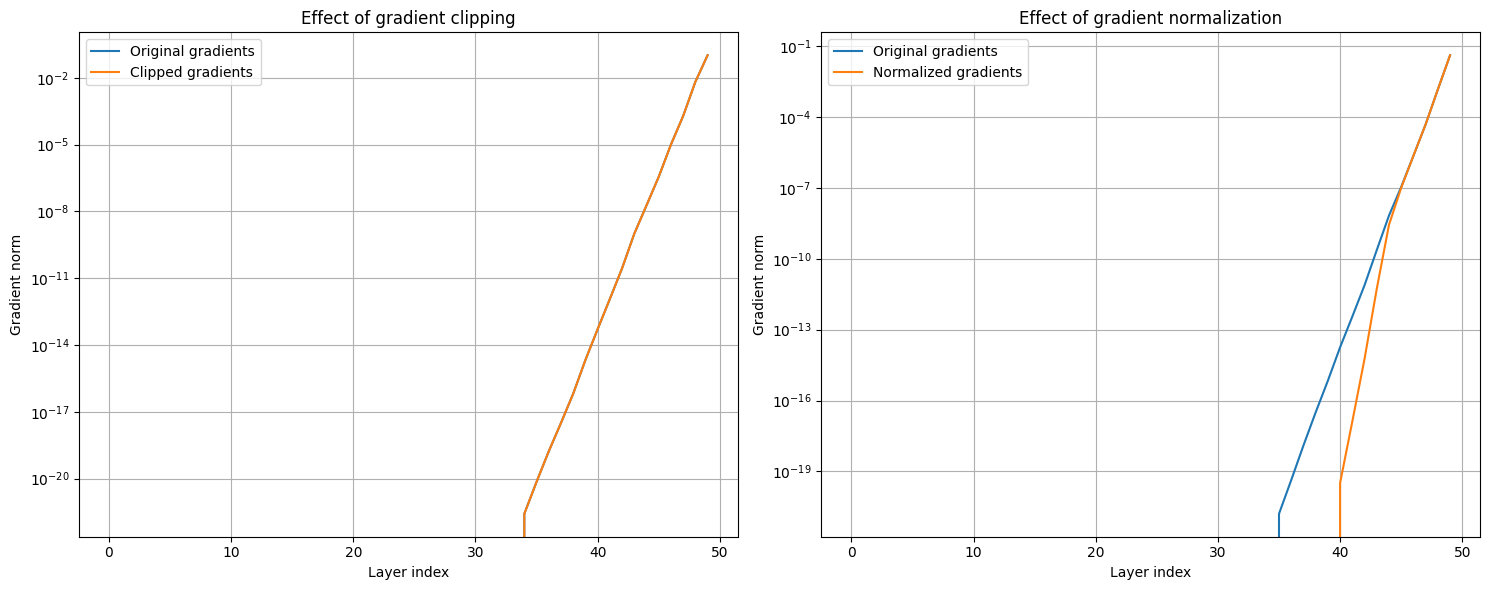

In [41]:
# 比较梯度裁剪和梯度归一化技术
compare_gradient_techniques()

4.3 改进激活函数和归一化层

In [42]:
# 创建具有不同激活函数和归一化层的深度网络
class ImprovedDeepNetwork(nn.Module):
    def __init__(self, depth=50, width=20, activation='tanh', normalization=None):
        super().__init__()
        self.layers = nn.ModuleList()
        
        for i in range(depth):
            layer_modules = [nn.Linear(width, width)]
            
            # 添加归一化层
            if normalization == 'batch_norm':
                layer_modules.append(nn.BatchNorm1d(width))
            elif normalization == 'layer_norm':
                layer_modules.append(nn.LayerNorm(width))
            
            # 添加激活函数
            if activation == 'tanh':
                layer_modules.append(nn.Tanh())
            elif activation == 'relu':
                layer_modules.append(nn.ReLU())
            elif activation == 'leaky_relu':
                layer_modules.append(nn.LeakyReLU(0.1))
            elif activation == 'elu':
                layer_modules.append(nn.ELU())
            elif activation == 'gelu':
                layer_modules.append(nn.GELU())
            
            self.layers.append(nn.Sequential(*layer_modules))
        
        self.output_layer = nn.Linear(width, 1)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

# 比较不同激活函数和归一化层对梯度分布的影响
def compare_activations_and_normalizations():
    depth = 50
    width = 20
    batch_size = 32
    
    # 创建随机输入数据和目标
    input_data = torch.randn(batch_size, width)
    target = torch.randn(batch_size, 1)
    
    # 定义要比较的配置
    configs = [
        {'activation': 'tanh', 'normalization': None, 'label': 'Tanh'},
        {'activation': 'relu', 'normalization': None, 'label': 'ReLU'},
        {'activation': 'leaky_relu', 'normalization': None, 'label': 'Leaky ReLU'},
        {'activation': 'elu', 'normalization': None, 'label': 'ELU'},
        {'activation': 'gelu', 'normalization': None, 'label': 'GELU'},
        {'activation': 'tanh', 'normalization': 'batch_norm', 'label': 'Tanh + BatchNorm'},
        {'activation': 'relu', 'normalization': 'batch_norm', 'label': 'ReLU + BatchNorm'},
        {'activation': 'tanh', 'normalization': 'layer_norm', 'label': 'Tanh + LayerNorm'},
        {'activation': 'relu', 'normalization': 'layer_norm', 'label': 'ReLU + LayerNorm'}
    ]
    
    plt.figure(figsize=(15, 12))
    
    # 子图1：比较不同激活函数
    plt.subplot(2, 1, 1)
    for config in configs[:5]:  # 只比较激活函数
        model = ImprovedDeepNetwork(
            depth=depth, 
            width=width, 
            activation=config['activation'], 
            normalization=config['normalization']
        )
        grad_norms = analyze_gradients(model, input_data, target)
        plt.plot(grad_norms, label=config['label'])
    
    # plt.title('不同激活函数对梯度分布的影响')
    # plt.xlabel('层索引')
    # plt.ylabel('梯度范数 (log尺度)')
    # plt.yscale('log')
    plt.title('Influence of different activation functions on gradient distribution')
    plt.xlabel('Layer index')
    plt.ylabel('Gradient norm (log scale)')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    
    # 子图2：比较归一化层的影响
    plt.subplot(2, 1, 2)
    for config in [configs[0], configs[5], configs[7]]:  # 比较Tanh与不同归一化层的组合
        model = ImprovedDeepNetwork(
            depth=depth, 
            width=width, 
            activation=config['activation'], 
            normalization=config['normalization']
        )
        grad_norms = analyze_gradients(model, input_data, target)
        plt.plot(grad_norms, label=config['label'])
    
    for config in [configs[1], configs[6], configs[8]]:  # 比较ReLU与不同归一化层的组合
        model = ImprovedDeepNetwork(
            depth=depth, 
            width=width, 
            activation=config['activation'], 
            normalization=config['normalization']
        )
        grad_norms = analyze_gradients(model, input_data, target)
        plt.plot(grad_norms, label=config['label'])
    
    # plt.title('归一化层对梯度分布的影响')
    # plt.xlabel('层索引')
    # plt.ylabel('梯度范数 (log尺度)')
    # plt.yscale('log')
    plt.title('Influence of normalization layers on gradient distribution')
    plt.xlabel('Layer index')
    plt.ylabel('Gradient norm (log scale)')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [51]:
def analyze_gradients(model, input_data, target):
    """分析模型各层的梯度分布"""
    # 前向传播
    output = model(input_data)
    loss = F.mse_loss(output, target)
    
    # 清空梯度
    model.zero_grad()
    
    # 反向传播
    loss.backward()
    
    # 收集不同层的梯度范数
    grad_norms = []
    for layer in model.layers:
        # 遍历Sequential模块中的所有子模块
        for module in layer:
            if isinstance(module, nn.Linear):
                if module.weight.grad is not None:
                    grad_norm = module.weight.grad.norm().item()
                    grad_norms.append(grad_norm)
    
    return grad_norms

# 比较不同激活函数和归一化层对梯度分布的影响
def compare_activations_and_normalizations():
    depth = 50
    width = 20
    batch_size = 32
    
    # 创建随机输入数据和目标
    input_data = torch.randn(batch_size, width)
    target = torch.randn(batch_size, 1)
    
    # 定义要比较的配置
    configs = [
        {'activation': 'tanh', 'normalization': None, 'label': 'Tanh'},
        {'activation': 'relu', 'normalization': None, 'label': 'ReLU'},
        {'activation': 'leaky_relu', 'normalization': None, 'label': 'Leaky ReLU'},
        {'activation': 'elu', 'normalization': None, 'label': 'ELU'},
        {'activation': 'gelu', 'normalization': None, 'label': 'GELU'},
        {'activation': 'tanh', 'normalization': 'batch_norm', 'label': 'Tanh + BatchNorm'},
        {'activation': 'relu', 'normalization': 'batch_norm', 'label': 'ReLU + BatchNorm'},
        {'activation': 'tanh', 'normalization': 'layer_norm', 'label': 'Tanh + LayerNorm'},
        {'activation': 'relu', 'normalization': 'layer_norm', 'label': 'ReLU + LayerNorm'}
    ]
    
    plt.figure(figsize=(15, 12))
    
    # 子图1：比较不同激活函数
    plt.subplot(2, 1, 1)
    for config in configs[:5]:  # 只比较激活函数
        model = ImprovedDeepNetwork(
            depth=depth, 
            width=width, 
            activation=config['activation'], 
            normalization=config['normalization']
        )
        grad_norms = analyze_gradients(model, input_data, target)
        plt.plot(grad_norms, label=config['label'])
    
    # plt.title('不同激活函数对梯度分布的影响')
    # plt.xlabel('层索引')
    # plt.ylabel('梯度范数 (log尺度)')
    # plt.yscale('log')
    plt.title('Impact of different activation functions on gradient distribution')
    plt.xlabel('Layer index')
    plt.ylabel('Gradient norm (log scale)')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    
    # 子图2：比较归一化层的影响
    plt.subplot(2, 1, 2)
    for config in [configs[0], configs[5], configs[7]]:  # 比较Tanh与不同归一化层的组合
        model = ImprovedDeepNetwork(
            depth=depth, 
            width=width, 
            activation=config['activation'], 
            normalization=config['normalization']
        )
        grad_norms = analyze_gradients(model, input_data, target)
        plt.plot(grad_norms, label=config['label'])
    
    for config in [configs[1], configs[6], configs[8]]:  # 比较ReLU与不同归一化层的组合
        model = ImprovedDeepNetwork(
            depth=depth, 
            width=width, 
            activation=config['activation'], 
            normalization=config['normalization']
        )
        grad_norms = analyze_gradients(model, input_data, target)
        plt.plot(grad_norms, label=config['label'])
    
    # plt.title('归一化层对梯度分布的影响')
    # plt.xlabel('层索引')
    # plt.ylabel('梯度范数 (log尺度)')
    # plt.yscale('log')
    plt.title('Effect of Normalization Layers on Gradient Distribution')
    plt.xlabel('Layer Index')
    plt.ylabel('Gradient Norm (Log Scale)')
    plt.yscale('log')

    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

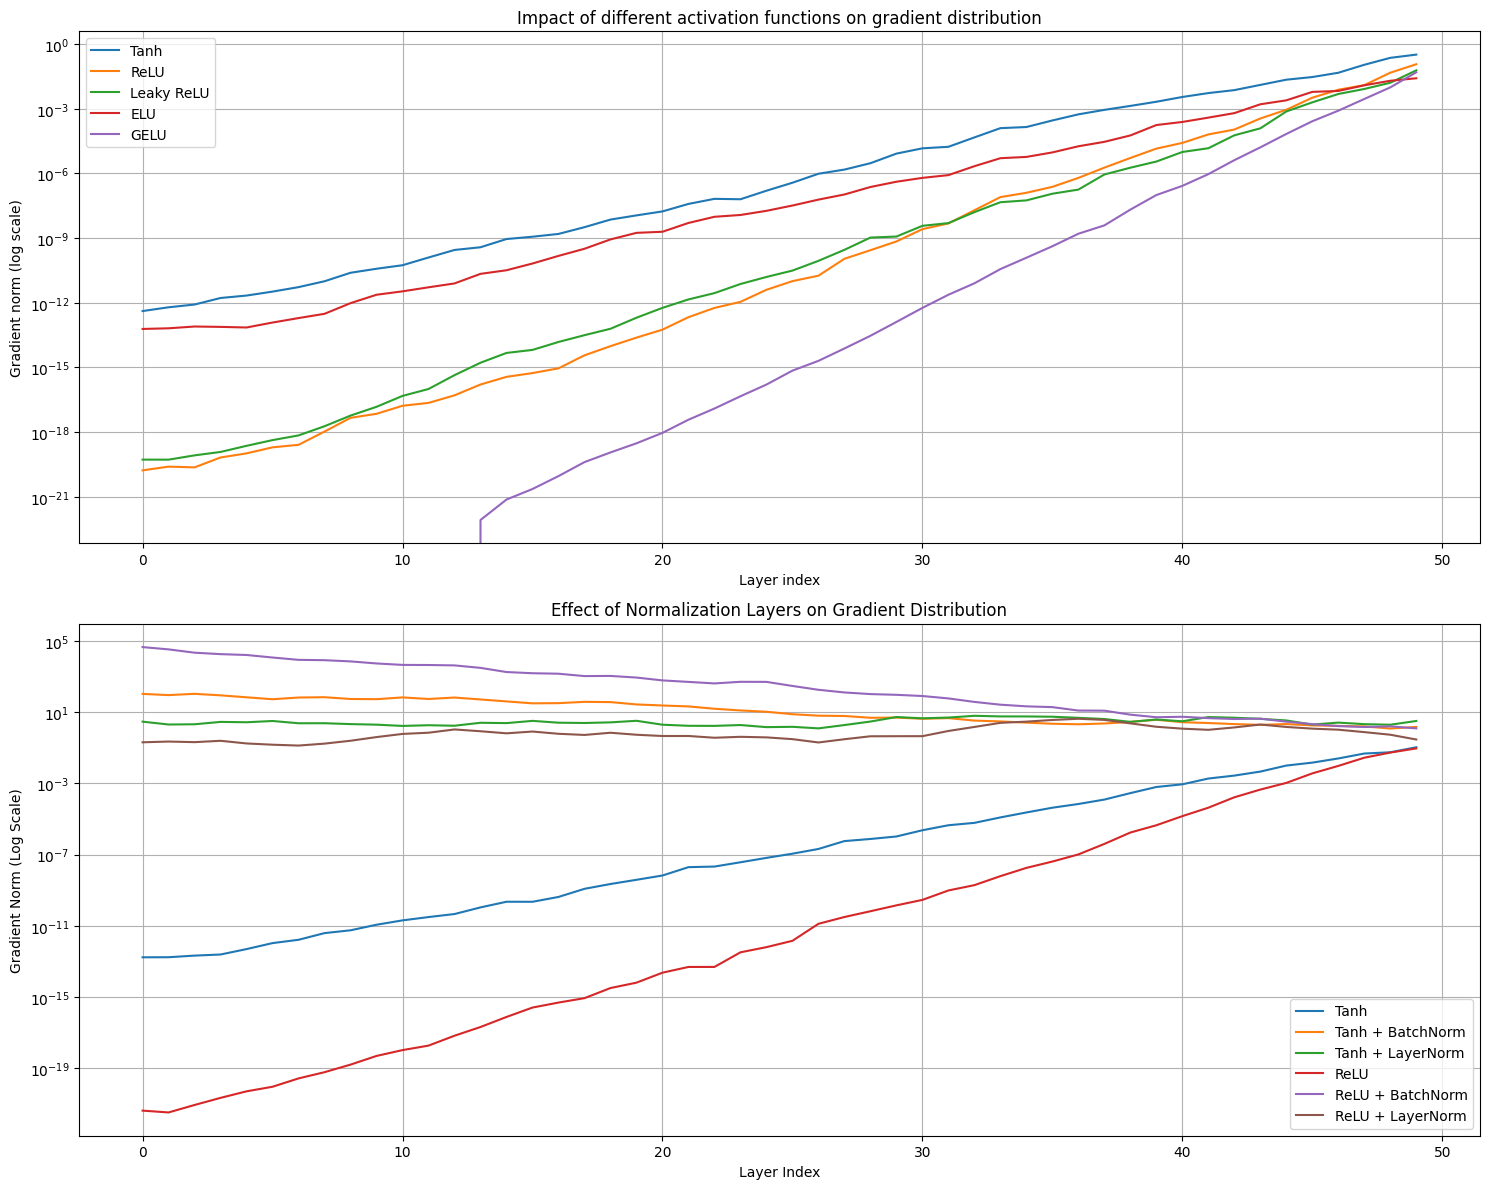

In [52]:
# 比较不同激活函数和归一化层的效果
compare_activations_and_normalizations()

4.4 残差连接的效果

In [ ]:
# 创建带有残差连接的深度网络
class ResidualNetwork(nn.Module):
    def __init__(self, depth=50, width=20, use_residual=True):
        super().__init__()
        self.use_residual = use_residual
        self.layers = nn.ModuleList()
        
        for i in range(depth):
            block = nn.Sequential(
                nn.Linear(width, width),
                nn.BatchNorm1d(width),
                nn.ReLU(),
                nn.Linear(width, width),
                nn.BatchNorm1d(width)
            )
            self.layers.append(block)
        
        self.relus = nn.ModuleList([nn.ReLU() for _ in range(depth)])
        self.output_layer = nn.Linear(width, 1)
    
    def forward(self, x):
        for i, (layer, relu) in enumerate(zip(self.layers, self.relus)):
            residual = x
            x = layer(x)
            if self.use_residual:
                x = x + residual  # 残差连接
            x = relu(x)
        return self.output_layer(x)

# 比较有无残差连接的网络梯度分布
def compare_residual_connections():
    depth = 50
    width = 20
    batch_size = 32
    
    # 创建随机输入数据和目标
    input_data = torch.randn(batch_size, width)
    target = torch.randn(batch_size, 1)
    
    # 创建带残差连接的模型
    model_with_residual = ResidualNetwork(depth=depth, width=width, use_residual=True)
    grad_norms_with_residual = analyze_gradients(model_with_residual, input_data, target)
    
    # 创建不带残差连接的模型
    model_without_residual = ResidualNetwork(depth=depth, width=width, use_residual=False)
    grad_norms_without_residual = analyze_gradients(model_without_residual, input_data, target)
    
    # 可视化比较
    plt.figure(figsize=(12, 6))
    plt.plot(grad_norms_with_residual, label='With residual connection')
    plt.plot(grad_norms_without_residual, label='Without residual connection')
    
    # plt.title('残差连接对梯度分布的影响')
    # plt.xlabel('层索引')
    # plt.ylabel('梯度范数 (log尺度)')
    # plt.yscale('log')
    plt.title('Influence of residual connections on gradient distribution')
    plt.xlabel('Layer index')
    plt.ylabel('Gradient norm (log scale)')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()

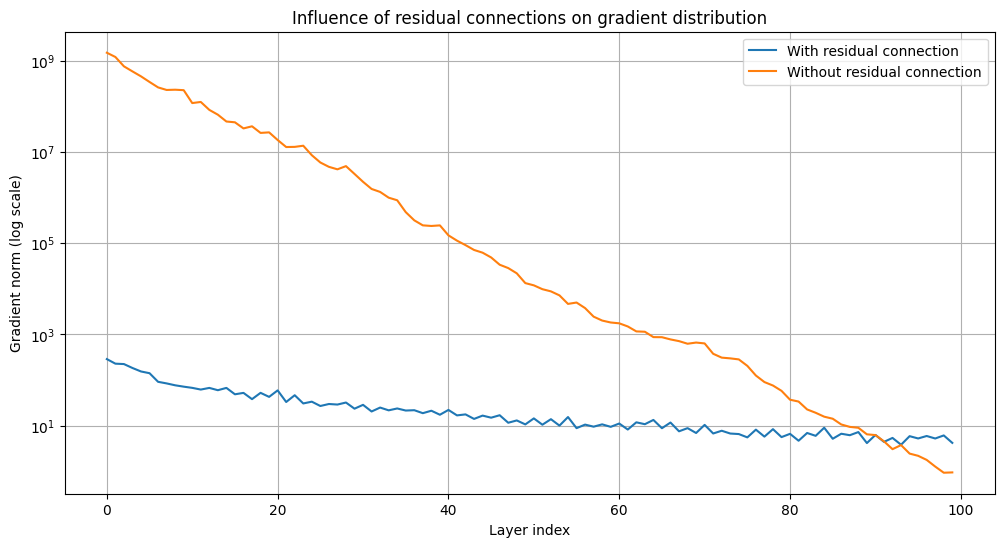

In [56]:
# 比较残差连接的效果
compare_residual_connections()

4.5 混合精度训练

In [46]:
# 演示混合精度训练
def train_with_mixed_precision(use_amp=False):
    # 检查CUDA是否可用
    if not torch.cuda.is_available():
        print("警告: CUDA不可用，混合精度训练需要GPU支持。跳过此演示。")
        return {}
    
    # 创建数据集和数据加载器
    train_dataset = SyntheticDataset(num_samples=50000, input_dim=300, num_classes=10)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    
    # 创建模型和优化器
    model = SimpleClassifier().cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # 创建梯度缩放器（用于混合精度训练）
    scaler = GradScaler() if use_amp else None
    
    # 训练循环
    epochs = 5
    metrics = {'train_time': [], 'memory_usage': [], 'loss': []}
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        start_time = time.time()
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            
            if use_amp:
                # 混合精度训练
                with autocast():
                    output = model(data)
                    loss = criterion(output, target)
                
                # 反向传播
                scaler.scale(lloss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # 标准训练
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            
            epoch_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        epoch_time = time.time() - start_time
        avg_loss = epoch_loss / len(train_loader)
        memory_allocated = torch.cuda.memory_allocated() / 1024**2  # MB
        
        metrics['train_time'].append(epoch_time)
        metrics['memory_usage'].append(memory_allocated)
        metrics['loss'].append(avg_loss)
        
        print(f'Epoch {epoch} - Loss: {avg_loss:.4f}, Time: {epoch_time:.2f}s, Memory: {memory_allocated:.2f} MB')
    
    return metrics

# 比较标准训练和混合精度训练的性能
def compare_training_efficiency():
    # 检查CUDA是否可用
    if not torch.cuda.is_available():
        print("警告: CUDA不可用，混合精度训练需要GPU支持。跳过此演示。")
        return
    
    print("运行标准精度训练 (FP32)...")
    standard_metrics = train_with_mixed_precision(use_amp=False)
    
    print("\n运行混合精度训练 (FP16)...")
    mixed_metrics = train_with_mixed_precision(use_amp=True)
    
    # 可视化比较
    if standard_metrics and mixed_metrics:
        plt.figure(figsize=(15, 5))
        
        # 训练时间比较
        plt.subplot(1, 3, 1)
        plt.bar(['标准精度', '混合精度'], 
                [sum(standard_metrics['train_time']), sum(mixed_metrics['train_time'])],
                color=['blue', 'orange'])
        plt.title('总训练时间 (秒)')
        plt.grid(axis='y')
        
        # 内存使用比较
        plt.subplot(1, 3, 2)
        plt.bar(['标准精度', '混合精度'], 
                [standard_metrics['memory_usage'][-1], mixed_metrics['memory_usage'][-1]],
                color=['blue', 'orange'])
        plt.title('GPU内存使用 (MB)')
        plt.grid(axis='y')
        
        # 损失曲线比较
        plt.subplot(1, 3, 3)
        plt.plot(standard_metrics['loss'], label='标准精度')
        plt.plot(mixed_metrics['loss'], label='混合精度')
        plt.title('训练损失')
        plt.xlabel('轮次')
        plt.ylabel('损失')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # 打印速度提升
        standard_time = sum(standard_metrics['train_time'])
        mixed_time = sum(mixed_metrics['train_time'])
        speedup = (standard_time - mixed_time) / standard_time * 100
        print(f"\n混合精度训练提速: {speedup:.2f}%")
        
        # 打印内存节省
        standard_mem = standard_metrics['memory_usage'][-1]
        mixed_mem = mixed_metrics['memory_usage'][-1]
        mem_saving = (standard_mem - mixed_mem) / standard_mem * 100
        print(f"内存节省: {mem_saving:.2f}%")

In [47]:
# 比较标准精度训练和混合精度训练的效率
# 注意：此单元格需要GPU支持
compare_training_efficiency()

警告: CUDA不可用，混合精度训练需要GPU支持。跳过此演示。


## 5. 总结与最佳实践

通过本notebook，我们演示了以下优化技术和最佳实践：

1. ​**参数初始化**​
   - 不同初始化方法的分布特性和适用场景
   - 初始化对训练稳定性的影响

2. ​**优化算法**​
   - 常见优化器的实现原理和收敛行为
   - 各类优化器在不同问题上的性能比较

3. ​**学习率调度策略**​
   - 各种学习率调度器的行为和适用场景
   - 预热和衰减策略的重要性

4. ​**常见问题的解决方案**​
   - 梯度消失/爆炸问题及其解决方法
   - 梯度裁剪和归一化技术
   - 激活函数和归一化层的选择
   - 残差连接的重要性
   - 混合精度训练提高效率

### 最佳实践建议

1. ​**网络初始化**​：
   - 对于ReLU激活，优先使用He/Kaiming初始化
   - 对于Tanh/Sigmoid激活，优先使用Xavier/Glorot初始化
   - 对于Transformer架构，使用标准差为0.02的正态分布初始化

2. ​**优化器选择**​：
   - 大多数情况下，Adam或AdamW是较好的默认选择
   - 对于某些CV任务，SGD+动量可能表现更好
   - 对于敏感的NLP任务，考虑使用Adafactor或AdamW

3. ​**学习率设置**​：
   - 使用线性预热后余弦衰减通常效果较好
   - 对于大批量训练，考虑线性缩放学习率
   - 使用学习率查找技术确定最佳初始学习率

4. ​**稳定训练技巧**​：
   - 在深度网络中使用残差连接
   - 使用合适的归一化层（BatchNorm, LayerNorm等）
   - 应用梯度裁剪防止梯度爆炸
   - 使用混合精度训练加速训练并节省内存

5. ​**调试和监控**​：
   - 监控激活值和梯度的统计分布
   - 观察权重更新的幅度
   - 定期检查梯度是否健康（不为NaN或无穷大）